Create a randomly selected sample of galaxies to see where pipeline benefits start to fall short.

In [1]:
from astropy.io import fits
from astropy.table import Table
import os
import numpy as np
from sklearn.utils import resample


In [2]:
file = '/Users/matt/Data/legacydata/sv3-clustering/BGS_BRIGHT_S_clustering.dat.fits'

In [4]:
bgs_bs = Table(fits.getdata( file))
print(bgs_bs.colnames)

['RA', 'DEC', 'TARGETID', 'NTILE', 'TILES', 'Z', 'COMP_TILE', 'rosette_number', 'rosette_r', 'FRACZ_TILELOCID', 'BITWEIGHTS', 'PROB_OBS', 'WEIGHT_ZFAIL', 'WEIGHT', 'flux_g_dered', 'flux_r_dered', 'flux_z_dered', 'flux_w1_dered', 'flux_w2_dered', 'REST_GMR_0P1', 'KCORR_R0P1', 'KCORR_G0P1', 'KCORR_R0P0', 'KCORR_G0P0', 'REST_GMR_0P0', 'EQ_ALL_0P0', 'EQ_ALL_0P1', 'ABSMAG_R', 'NZ', 'WEIGHT_FKP']


15.849391
15088.81


(array([7.5006e+04, 5.7000e+02, 1.9400e+02, 4.3000e+01, 3.8000e+01,
        1.4000e+01, 6.0000e+00, 7.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([ 1.   ,  1.975,  2.95 ,  3.925,  4.9  ,  5.875,  6.85 ,  7.825,
         8.8  ,  9.775, 10.75 ]),
 <BarContainer object of 10 artists>)

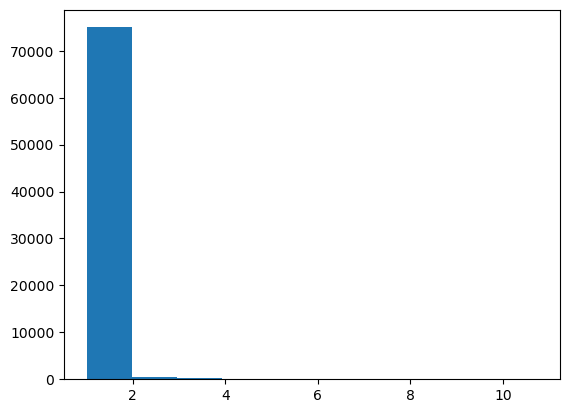

In [5]:
import matplotlib.pyplot as plt
print(min(bgs_bs['flux_r_dered']))
print(max(bgs_bs['flux_r_dered']))

plt.hist(bgs_bs["WEIGHT"])

In [6]:
def flux_to_mag(flux):
    return (-5/2)*np.log10(flux) + 22.5

def mag_to_flux(mag):
    return 10**((2/5)* (22.5 - mag))

bgs_bs["mag_r_dered"] = flux_to_mag(bgs_bs["flux_r_dered"])
bgs_bs["mag_g_dered"] = flux_to_mag(bgs_bs["flux_g_dered"])
bgs_bs["mag_z_dered"] = flux_to_mag(bgs_bs["flux_z_dered"])

Using
$$
mag = -\frac{5}{2} \log_{10}(f) + 22.5
$$
and
$$
f = 10^{\frac{2}{5}(22.5-mag)}
$$
For nanomaggies

In [8]:
# slow_ids = [39628454575999975, 39627884993708166]
slow_ids = [39628454575999975]
slow_galaxies = bgs_bs[np.isin(bgs_bs['TARGETID'], slow_ids)]
slow_galaxies.write(f'/Users/matt/Data/legacydata/sv3-clustering/debug_39628454575999975.fits', overwrite=True)

fast_ids = [39627739988230699]
fast_galaxies = bgs_bs[np.isin(bgs_bs['TARGETID'], fast_ids)]
fast_galaxies.write(f'/Users/matt/Data/legacydata/sv3-clustering/debug_39627739988230699.fits', overwrite=True)

slow_galaxies
# fast_galaxies[0]
# print(slow_galaxies[0]['Z', 'mag_r_dered'])


RA,DEC,TARGETID,NTILE,TILES,Z,COMP_TILE,rosette_number,rosette_r,FRACZ_TILELOCID,BITWEIGHTS,PROB_OBS,WEIGHT_ZFAIL,WEIGHT,flux_g_dered,flux_r_dered,flux_z_dered,flux_w1_dered,flux_w2_dered,REST_GMR_0P1,KCORR_R0P1,KCORR_G0P1,KCORR_R0P0,KCORR_G0P0,REST_GMR_0P0,EQ_ALL_0P0,EQ_ALL_0P1,ABSMAG_R,NZ,WEIGHT_FKP,mag_r_dered,mag_g_dered,mag_z_dered
float64,float64,int64,int64,str43,float64,float64,float64,float64,float64,int64[2],float64,float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32
194.41128243343505,28.669273309737786,39628454575999975,7,120-124-125-126-127-128-129,0.019347997617750242,1.0,4.0,0.5558183491523893,1.0,-1 .. -1,1.0,1.0,1.0,38.402855,70.525406,104.32747,51.266727,25.781889,0.7496183213943896,-0.19954506730425836,-0.28920741030488684,0.02722243336213248,0.030283741931249664,0.6568946698244376,-0.018767557689217736,-0.018767557689217736,-15.751453242161187,0.3270132189900589,0.00045280624400793255,17.879135,18.539091,17.454002


In [42]:
print([2**x for x in range(1, 15)])
N_sample = 1024

[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]


1024


(array([0.00156704, 0.00156704, 0.00626817, 0.0109693 , 0.02350568,
        0.05327947, 0.10029076, 0.23192238, 0.40273008, 0.77255226]),
 array([13.26808071, 13.89126873, 14.51445675, 15.13764477, 15.76083279,
        16.38401985, 17.00720787, 17.63039589, 18.25358391, 18.87677193,
        19.49995995]),
 [<matplotlib.patches.Polygon at 0x7f8a51b5a940>])

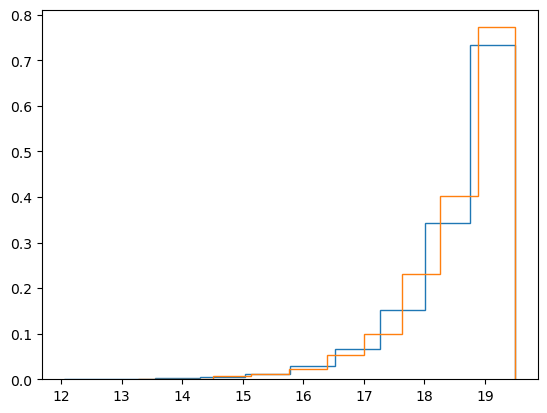

In [43]:
import matplotlib.pyplot as plt

plt.hist(bgs_bs['mag_r_dered'], histtype='step', density=True)

random_ids = np.random.choice(bgs_bs['TARGETID'], N_sample, replace=False)
print(len(random_ids))
randoms = bgs_bs[np.isin(bgs_bs['TARGETID'], random_ids)]

plt.hist(randoms['mag_r_dered'], histtype='step', density=True)


In [44]:
print(len(randoms))
randoms.write(f'/Users/matt/Data/legacydata/sv3-clustering/{N_sample}_randoms_tuning.fits', overwrite=True)

1024


In [18]:

def resample_by_bin(min, max, bgs, n_sample):
    
    mask = (bgs['flux_r_dered'] >= min) & (bgs['flux_r_dered'] < max)
    bgs_cut = bgs[mask]
    if n_sample > len(bgs_cut):
        return bgs_cut

    ids = bgs_cut['TARGETID']
    strat = bgs_cut['flux_r_dered']

    subsample_ids = resample(ids, replace=False, n_samples=n_sample, stratify=strat)
    return bgs_cut[np.isin(bgs_cut['TARGETID'], subsample_ids)]


In [23]:
resamples = []

for i in range(len(flux_bins)-1):
    print(flux_bins[i])
    resamples.append(resample_by_bin(flux_bins[i+1], flux_bins[i], bgs_bs, 100))

14996.84835502377
7557.880136804536
3808.9037649813595
1919.552523761383
967.3864499689537
487.528490103386
245.6970827636836
123.82262309589933
62.40221421389766
31.448504654769607


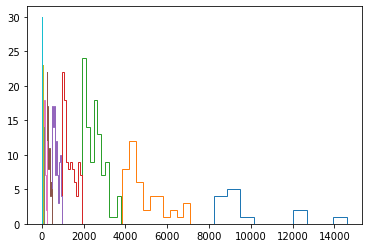

In [24]:
for s in resamples:
    plt.hist(s['flux_r_dered'], histtype='step')

In [25]:
for s in resamples:
    fname = f"subsampled_bgs_min_{min(s['flux_r_dered']):.2f}_max_{max(s['flux_r_dered']):.2f}.fits"
    print(fname)
    s.write('/global/homes/m/mkwiecie/desi/sv3-clustering/subsampled_bgs/'+fname, overwrite=True)

subsampled_bgs_min_8235.47_max_14582.40.fits
subsampled_bgs_min_3860.05_max_7096.44.fits
subsampled_bgs_min_1922.97_max_3773.81.fits
subsampled_bgs_min_968.14_max_1908.68.fits
subsampled_bgs_min_492.14_max_957.75.fits
subsampled_bgs_min_246.13_max_480.84.fits
subsampled_bgs_min_124.30_max_241.02.fits
subsampled_bgs_min_62.70_max_123.38.fits
subsampled_bgs_min_31.50_max_62.21.fits
subsampled_bgs_min_15.85_max_29.39.fits
